In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers,optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from skimage import io
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from tensorflow.keras import backend as K
from IPython.display import display_json
from sklearn.preprocessing import StandardScaler,normalize
import os
import glob
import random
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import  accuracy_score

In [2]:
data = pd.read_csv('Brain_MRI/data_mask.csv')
print(data.shape)
data

(3929, 4)


patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [4]:
data['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

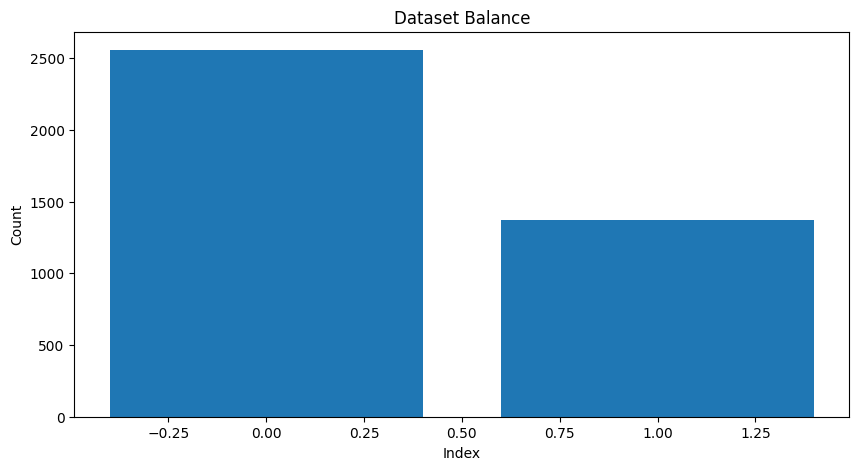

In [5]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(data['mask'].value_counts().index, data['mask'].value_counts())
 
plt.xlabel("Index")
plt.ylabel("Count")
plt.title("Dataset Balance")
plt.show()


In [6]:
data.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [7]:
data.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

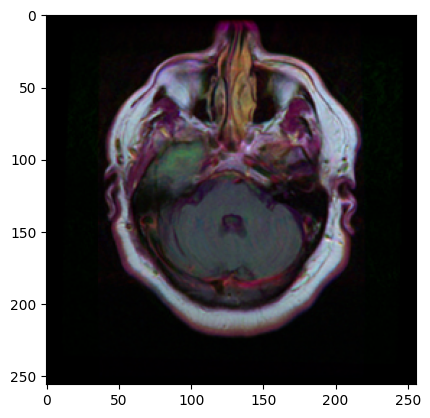

In [8]:
img = cv2.imread('Brain_MRI/'+data.image_path[623])
plt.imshow(img)

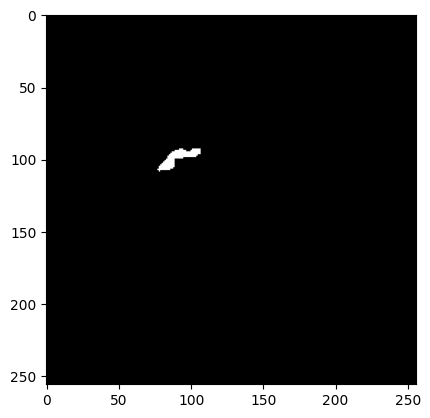

In [9]:
img = cv2.imread('Brain_MRI/'+data.mask_path[623])
plt.imshow(img)

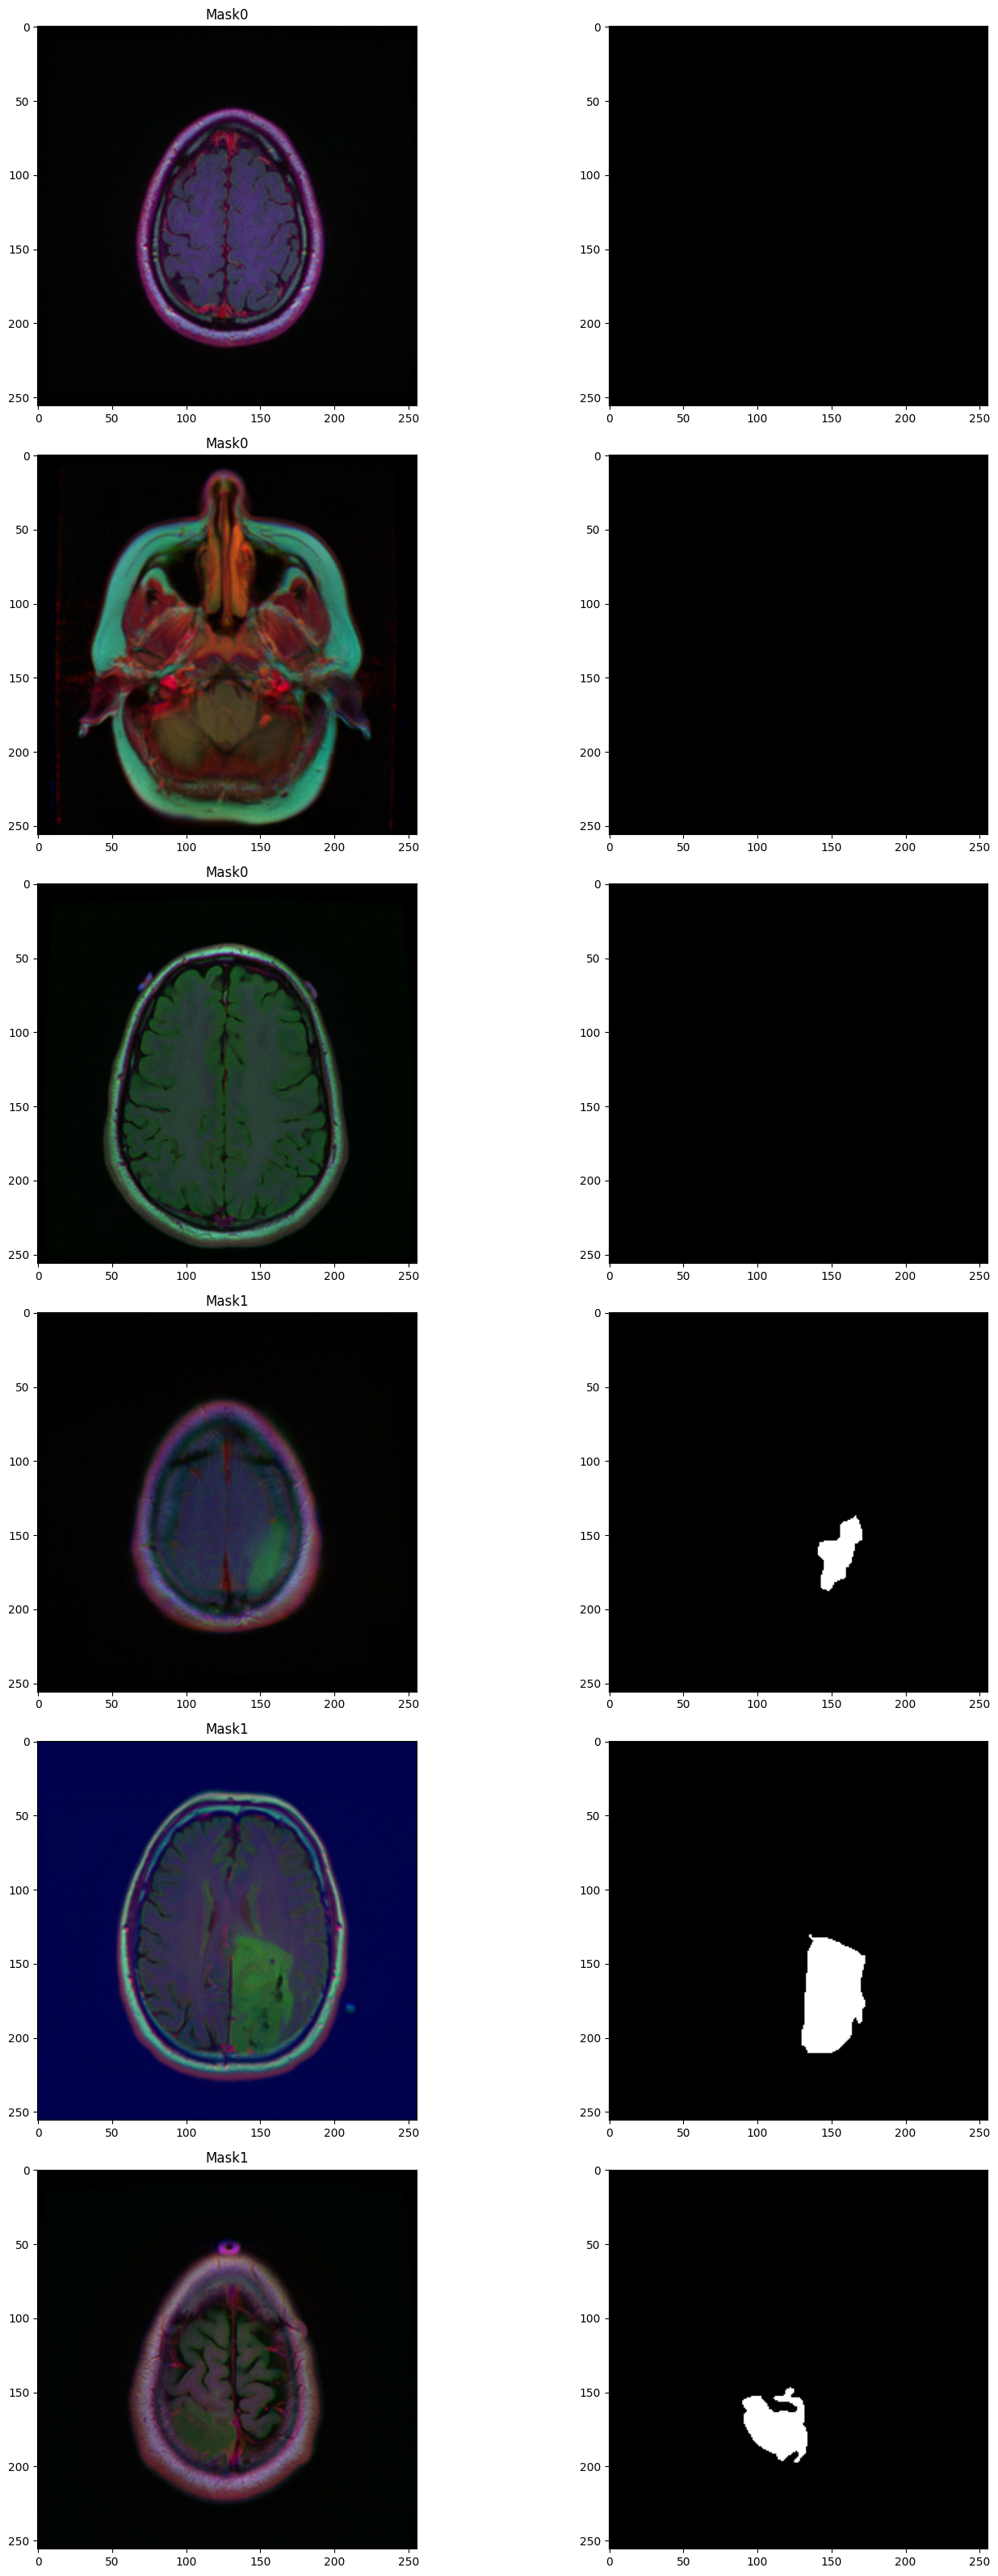

In [10]:
fig,axs = plt.subplots(6,2,figsize=(16,32))
count = 0
for i in range(6):
    i = random.randint(0,len(data))
    axs[count][0].title.set_text("Brain Mri")
    axs[count][0].imshow(cv2.imread('Brain_Mri/'+data.image_path[i]))
    axs[count][0].title.set_text("Mask"+str(data['mask'][i]))
    axs[count][1].imshow(cv2.imread('Brain_Mri/'+data.mask_path[i]))
    count+=1
    
    
fig.tight_layout()
    

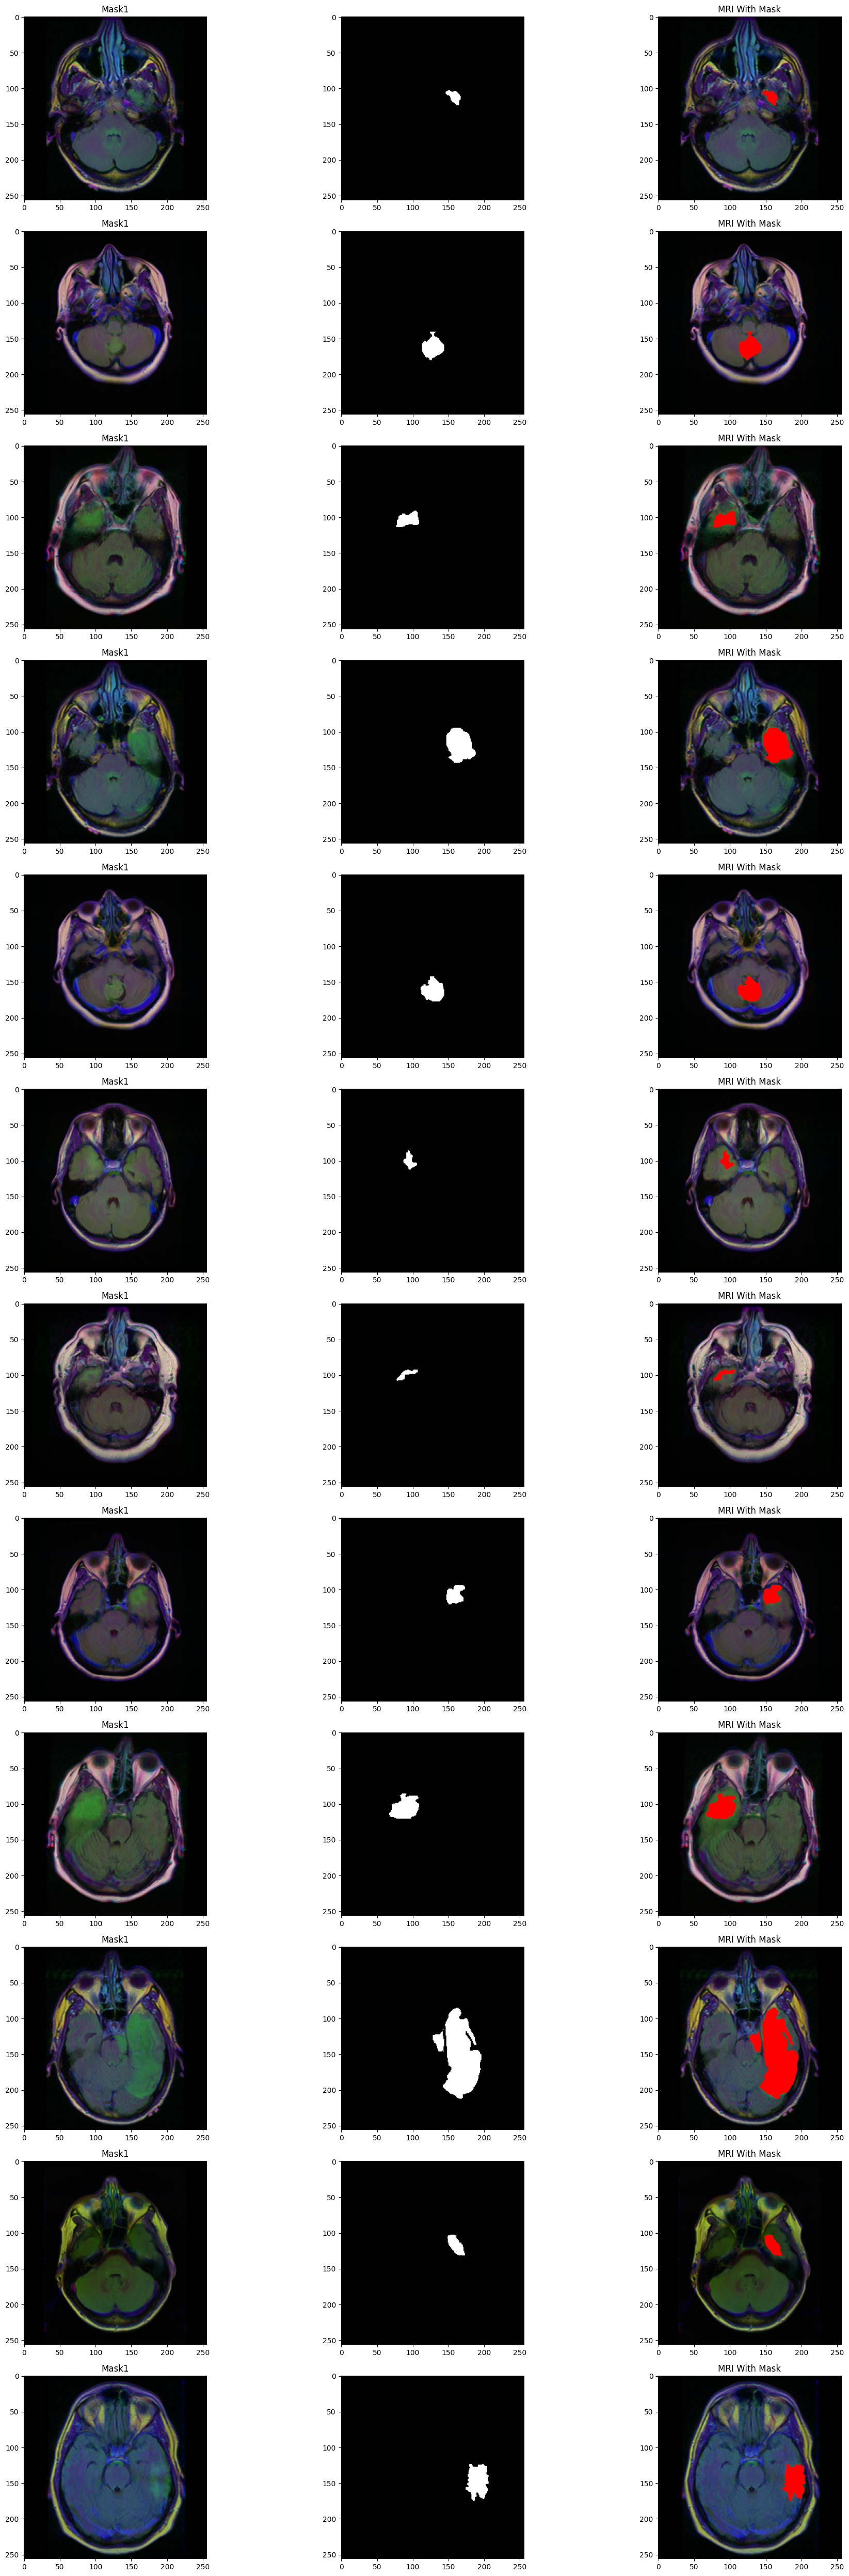

In [11]:
fig,axs = plt.subplots(12,3,figsize=(20,50))
count = 0
for i in range(len(data)):
    if data['mask'][i] == 1 and count<12:
        
        img = io.imread('Brain_MRI/'+data.image_path[i])
        axs[count][0].title.set_text("Brain Mri")
        axs[count][0].imshow(img)
        
        
        mask = io.imread('Brain_MRI/'+data.mask_path[i])
        axs[count][0].title.set_text("Mask"+str(data['mask'][i]))
        axs[count][1].imshow(mask,cmap='gray')
        
        img[mask == 255] = (255,0,0)
        axs[count][2].title.set_text("MRI With Mask")
        axs[count][2].imshow(img)
        count +=1
    
fig.tight_layout()

In [12]:
data

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [13]:
data.drop("patient_id",axis=1,inplace=True)
data

image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 3 columns]

In [14]:
data['mask'] = data['mask'].apply(lambda x :str(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [15]:


train,test = train_test_split(data,test_size=.15)

In [16]:

datagen = ImageDataGenerator(rescale=1./255.,validation_split=.15)

In [17]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./Brain_MRI/',
    x_col='image_path',
    y_col='mask',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256,256)
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./Brain_MRI/',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256,256)
)

tst_datagen = ImageDataGenerator(rescale=1./255.)

test_gen = tst_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./Brain_MRI/',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256,256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [18]:
basemodel = ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

In [19]:
for layer in basemodel.layers:
    layers.trainable = False

In [20]:
headmodel = basemodel.output

In [21]:
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(.3)(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(.3)(headmodel)
headmodel = Dense(2,activation='softmax')(headmodel)

model = Model(inputs=basemodel.input,outputs=headmodel)


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
earlystopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)
checkpointer = ModelCheckpoint(filepath='classifier-resnet-weights.hdf5',verbose=1,save_best_only=True)

In [25]:
# history = model.fit(train_gen,steps_per_epoch=train_gen.n//16,epochs=1,validation_data=valid_gen,validation_steps=valid_gen.n//16,callbacks=[checkpointer,earlystopping])

In [26]:
model_json = model.to_json()
with open("classifier-resnet-weights.json",'w') as json_file:
    json_file.write(model_json)

In [27]:
with open('resnet-50-MRI.json','r') as json_file:
    json_saveModel = json_file.read()
model = tf.keras.models.model_from_json(json_saveModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
test_predict = model.predict(test_gen,steps=test_gen.n//16,verbose=1)

36/36 [==============================] - 367s 10s/step


In [29]:
test_predict.shape

(576, 2)

In [30]:
test_predict

array([[1.0000000e+00, 1.0144898e-10],
       [9.9998713e-01, 1.2929956e-05],
       [6.3060142e-02, 9.3693984e-01],
       ...,
       [1.0000000e+00, 4.2198195e-08],
       [9.9977905e-01, 2.2100618e-04],
       [2.2142579e-09, 1.0000000e+00]], dtype=float32)

In [31]:
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))
    
predict = np.asanyarray(predict)

In [32]:
predict

array(['0', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0',
       '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1',
       '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0',
       '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '1',
       '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0',
       '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0',
       '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1',
       '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1',
       '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0

In [33]:
org = np.asanyarray(test['mask'])[:len(predict)]
len(org)

576

In [34]:
accuracy = accuracy_score(org,predict)
accuracy

0.984375

<AxesSubplot: >

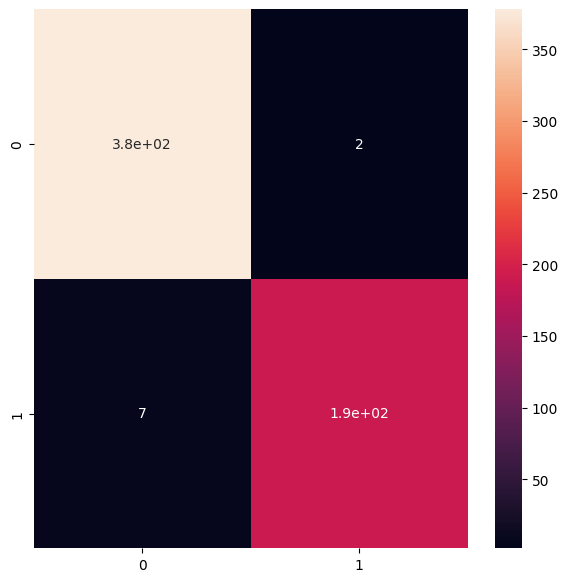

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(org,predict)
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True)

In [36]:
from sklearn.metrics import classification_report
cr = classification_report(org,predict,labels=[0,1])
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       380
           1       0.99      0.96      0.98       196

   micro avg       0.98      0.98      0.98       576
   macro avg       0.99      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



c:\Users\Amr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
c:\Users\Amr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
c:\Users\Amr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
c:\Users\Amr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
